In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import LeavePOut

In [73]:
df_jinhyeok = pd.read_csv("./data/진혁_데이터프레임.csv")
df_jinhyeok.rename(columns={"Unnamed: 0":"행정구역","Unnamed: 1":"계절","Unnamed: 2":"연도"},inplace=True)

month_spring = ["_3","_4","_5"]           # ["_3","_4","_5"]
month_summer = ["_6","_7","_8"]      # ["_5","_6","_7","_8"]
month_fall = ["_9","_10","_11"]      # ["_8","_9","_10","_11"]
month_winter = ["_10","_11","_12"]      # ["_8","_9","_10","_11","_12","_1","_2"]

season = ["spring", "summer", "fall", "winter"]

for i in range(len(season)) : 
    globals()["df_"+season[i]] = df_jinhyeok[df_jinhyeok["계절"]==season[i]]  # 계절별로 데이터 프레임 형성
    globals()["df_"+season[i]] = globals()["df_"+season[i]].groupby(["행정구역","계절","연도"]).mean()   # 행정구역, 계절, 연도를 인덱스로 groupby

In [3]:
# df=df[df['행정구역']=='강원도']
# df=pd.pivot_table(df, index=["일시", '행정구역'],aggfunc="mean")
# df=df.query('일시.str.contains("03|04|05")', engine='python')
# df=df.query('일시.str.contains("2000")', engine='python')

In [74]:
spr = "|".join(w for w in month_spring)

In [5]:
# df_spring.columns[df_spring.columns.str.contains(spr+"|면적|생산")]

In [75]:
for i in range(len(season)) : 
    globals()["month_str_"+season[i]] = "|".join(w for w in globals()["month_"+season[i]])  # 각 계절별 월을 | 으로 join
    
    # 각 계절이 속하는 월과 면적, 생산이 속하는 컬럼명을 리스트로 저장
    globals()["col_of_"+season[i]] = globals()["df_"+season[i]].columns[globals()["df_"+season[i]].columns.str.contains(globals()["month_str_"+season[i]]+"|면적|생산")]

In [77]:
# print(month_spring)
# print(col_of_spring)

In [76]:
# 데이터프레임을 계절별로 분리
df_spring = df_spring[col_of_spring]
df_summer = df_summer[col_of_summer]
df_fall = df_fall[col_of_fall]
df_winter = df_winter[col_of_winter]

In [78]:
df_winter.dropna(how="any",inplace=True)
# df_winter

In [79]:
city = ["서울특별시", "부산광역시", "대구광역시", "인천광역시", "광주광역시", "대전광역시", "울산광역시", "세종특별자치시", "경기도", "강원도", "충청북도", "충청남도", "전라북도", "전라남도", "경상북도", "경상남도", "제주도"]
city = sorted(city)
# city

In [80]:
median_city = []
for City in city : 
    m = df_fall.loc[(City),"면적 (ha)"].mean()    # 행정구역별로 면적의 평균값을 저장
    median_city.append(m)
# median_city

In [81]:
# 면적도 0이고 생산량도 0인 행에, 행정구역별 평균값 채우기
for i in range(len(df_spring)) : 
    if (df_spring.iloc[i,-2]==0) and (df_spring.iloc[i,-1]==0) : 
        a = df_spring.iloc[i].to_frame().columns
        b = a[0][0]
        c = city.index(b)
        m = median_city[c]
        df_spring.loc[a,"면적 (ha)"] = m

# df_spring[df_spring["면적 (ha)"] == 0]


In [82]:
for i in range(len(df_summer)) : 
    if (df_summer.iloc[i,-2]==0) and (df_summer.iloc[i,-1]==0) : 
        a = df_summer.iloc[i].to_frame().columns
        b = a[0][0]
        c = city.index(b)
        m = median_city[c]
        df_summer.loc[a,"면적 (ha)"] = m

for i in range(len(df_fall)) : 
    if (df_fall.iloc[i,-2]==0) and (df_fall.iloc[i,-1]==0) : 
        a = df_fall.iloc[i].to_frame().columns
        b = a[0][0]
        c = city.index(b)
        m = median_city[c]
        df_fall.loc[a,"면적 (ha)"] = m


In [83]:
for i in range(len(df_winter)) : 
    if (df_winter.iloc[i,-2]==0) and (df_winter.iloc[i,-1]==0) : 
        a = df_winter.iloc[i].to_frame().columns
        b = a[0][0]
        c = city.index(b)
        m = median_city[c]
        df_winter.loc[a,"면적 (ha)"] = m


In [84]:
df_spring.fillna(0,inplace=True)
df_summer.fillna(0,inplace=True)
df_fall.fillna(0,inplace=True)

print(df_spring.info())


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 374 entries, ('강원도', 'spring', 2000) to ('충청북도', 'spring', 2021)
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   평균기온(°C)_3월            374 non-null    float64
 1   최고기온(°C)_3월            374 non-null    float64
 2   최저기온(°C)_3월            374 non-null    float64
 3   월합강수량(00~24h만)(mm)_3월  374 non-null    float64
 4   합계 일사량(MJ/m2)_3월       374 non-null    float64
 5   평균기온(°C)_4월            374 non-null    float64
 6   최고기온(°C)_4월            374 non-null    float64
 7   최저기온(°C)_4월            374 non-null    float64
 8   월합강수량(00~24h만)(mm)_4월  374 non-null    float64
 9   합계 일사량(MJ/m2)_4월       374 non-null    float64
 10  평균기온(°C)_5월            374 non-null    float64
 11  최고기온(°C)_5월            374 non-null    float64
 12  최저기온(°C)_5월            374 non-null    float64
 13  월합강수량(00~24h만)(mm)_5월  374 non-null    float64
 14  합계 일사량(MJ/m2)_5

In [53]:
# df_spring[:30]

In [85]:
df_spring.columns = ['평균기온(°C)_상', '최고기온(°C)_상', '최저기온(°C)_상', '월합강수량(00~24h만)(mm)_상',
       '합계 일사량(MJ/m2)_상', '평균기온(°C)_중', '최고기온(°C)_중', '최저기온(°C)_중',
       '월합강수량(00~24h만)(mm)_중', '합계 일사량(MJ/m2)_중', '평균기온(°C)_하',
       '최고기온(°C)_하', '최저기온(°C)_하', '월합강수량(00~24h만)(mm)_하',
       '합계 일사량(MJ/m2)_하', '면적 (ha)', '생산량 (톤)']

In [86]:
df_summer.columns = ['평균기온(°C)_상', '최고기온(°C)_상', '최저기온(°C)_상', '월합강수량(00~24h만)(mm)_상',
       '합계 일사량(MJ/m2)_상', '평균기온(°C)_중', '최고기온(°C)_중', '최저기온(°C)_중',
       '월합강수량(00~24h만)(mm)_중', '합계 일사량(MJ/m2)_중', '평균기온(°C)_하',
       '최고기온(°C)_하', '최저기온(°C)_하', '월합강수량(00~24h만)(mm)_하',
       '합계 일사량(MJ/m2)_하', '면적 (ha)', '생산량 (톤)']

df_fall.columns = ['평균기온(°C)_상', '최고기온(°C)_상', '최저기온(°C)_상', '월합강수량(00~24h만)(mm)_상',
       '합계 일사량(MJ/m2)_상', '평균기온(°C)_중', '최고기온(°C)_중', '최저기온(°C)_중',
       '월합강수량(00~24h만)(mm)_중', '합계 일사량(MJ/m2)_중', '평균기온(°C)_하',
       '최고기온(°C)_하', '최저기온(°C)_하', '월합강수량(00~24h만)(mm)_하',
       '합계 일사량(MJ/m2)_하', '면적 (ha)', '생산량 (톤)']

df_winter.columns = ['평균기온(°C)_상', '최고기온(°C)_상', '최저기온(°C)_상', '월합강수량(00~24h만)(mm)_상',
       '합계 일사량(MJ/m2)_상', '평균기온(°C)_중', '최고기온(°C)_중', '최저기온(°C)_중',
       '월합강수량(00~24h만)(mm)_중', '합계 일사량(MJ/m2)_중', '평균기온(°C)_하',
       '최고기온(°C)_하', '최저기온(°C)_하', '월합강수량(00~24h만)(mm)_하',
       '합계 일사량(MJ/m2)_하', '면적 (ha)', '생산량 (톤)']

In [87]:
df_total = pd.concat([df_spring, df_summer, df_fall, df_winter])
df_total.head()

평균기온(°C)_상  최고기온(°C)_상  최저기온(°C)_상  월합강수량(00~24h만)(mm)_상  \
행정구역 계절     연도                                                               
강원도  spring 2000        4.40       19.30        -8.6                 14.10   
            2001        5.25       19.75        -8.6                  2.55   
            2002        7.30       19.70        -7.3                 33.10   
            2003        6.60       21.30        -6.0                 28.50   
            2004        6.90       20.30        -4.9                 19.90   

                  합계 일사량(MJ/m2)_상  평균기온(°C)_중  최고기온(°C)_중  최저기온(°C)_중  \
행정구역 계절     연도                                                          
강원도  spring 2000           448.65       10.40        23.7        -3.1   
            2001           455.28       10.85        23.7        -2.2   
            2002           519.21       12.70        24.8        -1.2   
            2003           523.00       11.90        25.9        -1.4   
            2004           481.75       12.60        25.4        -0.5   

                  월합강수량(00~24h만)(mm)_중  합계 일사량(MJ/m2)_중  평균기온(°C)_하  \
행정구역 계절     연도                                                        
강원도  spring 2000                 37.10          486.355       15.90   
            2001                 23.55          530.950       17.05   
            2002                 50.00          542.480       17.70   
            2003                 49.00          540.765       17.50   
            2004                 16.30          537.210       17.80   

                  최고기온(°C)_하  최저기온(°C)_하  월합강수량(00~24h만)(mm)_하  \
행정구역 계절     연도                                                   
강원도  spring 2000        31.6        3.90                 75.20   
            2001        31.4        5.55                 67.55   
            2002        34.1        5.70                 65.00   
            2003        34.5        5.60                 52.60   
            2004        33.9        5.80                 47.70   

                  합계 일사량(MJ/m2)_하  면적 (ha)   생산량 (톤)  
행정구역 계절     연도                                        
강원도  spring 2000          520.280   2147.0   87619.0  
            2001          562.770   1983.0   83405.0  
            2002          586.320   1329.0   56908.0  
            2003          586.195   1735.0   82760.0  
            2004          540.490   2133.0  100486.0

In [17]:
# len(df_spring.values.T[0])

In [18]:
# corr[16]

<AxesSubplot:>

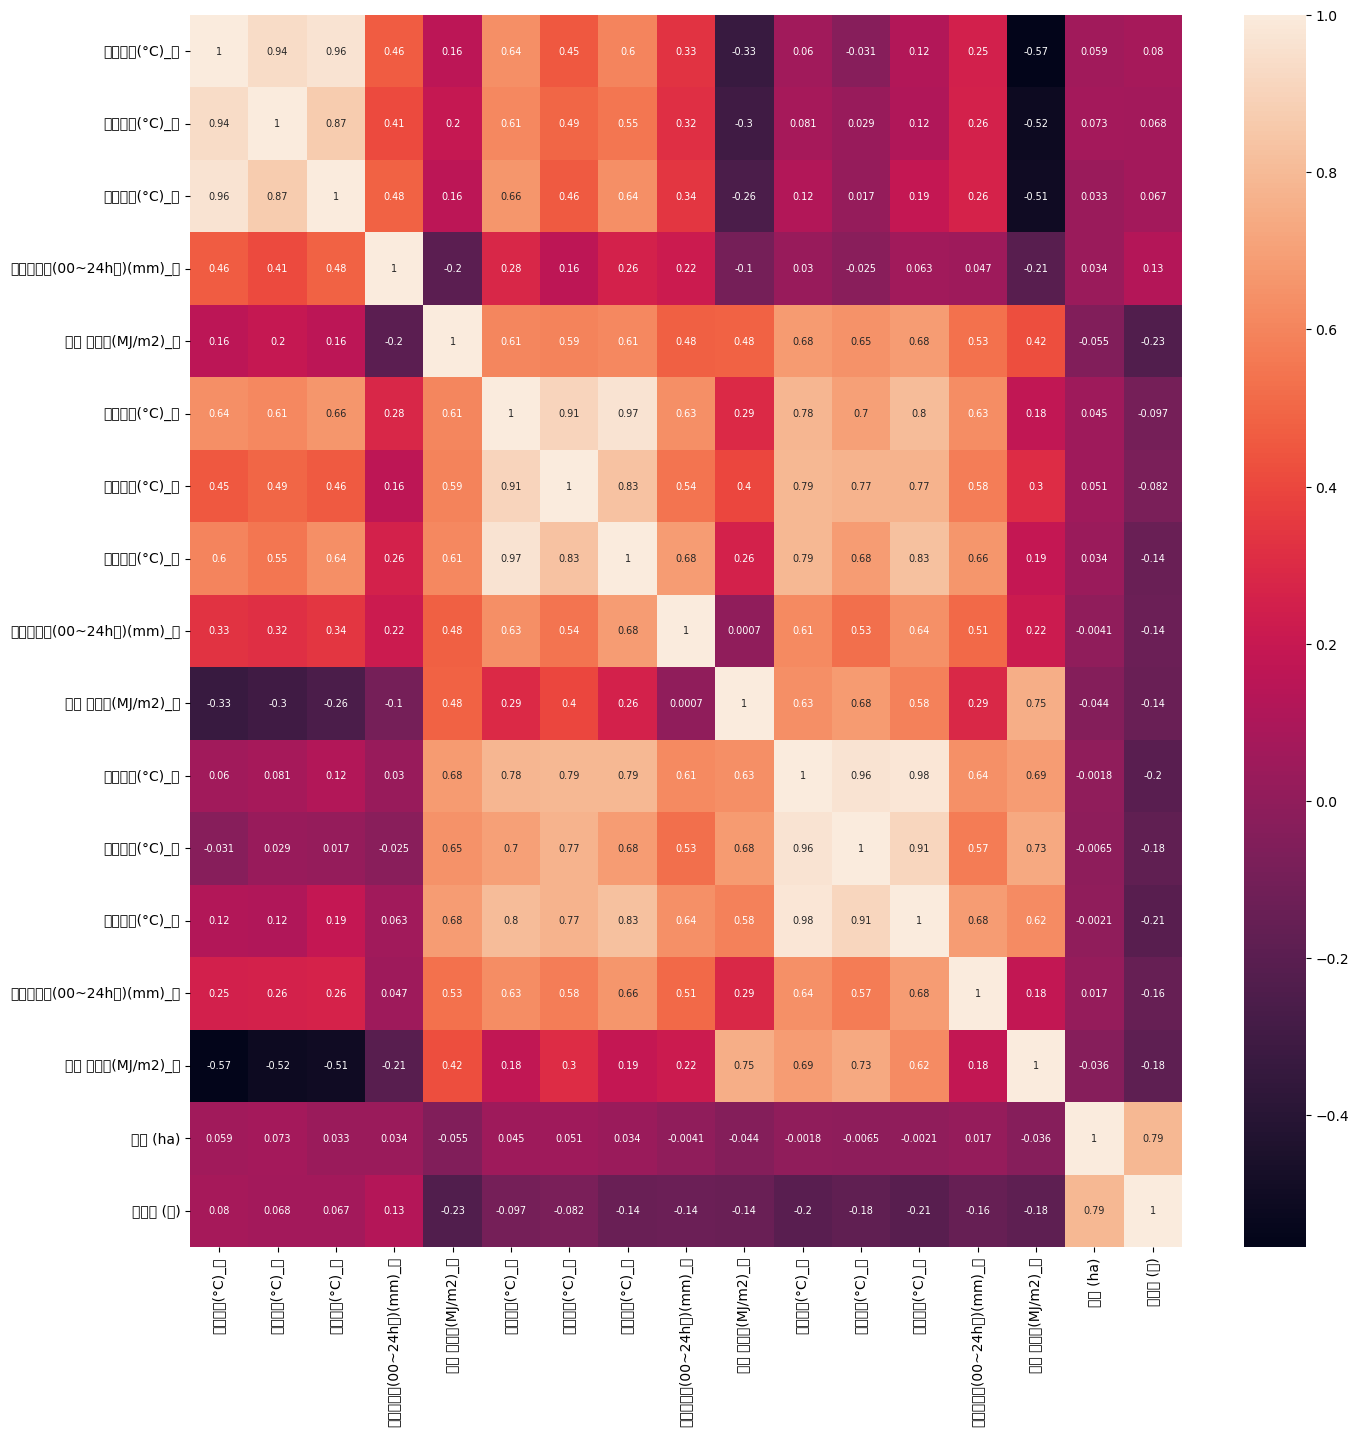

In [88]:
corr = np.corrcoef(df_total.values.T)
fig = plt.figure(figsize=(16,16))
sns.heatmap(corr, cbar=True, annot=True, square=False, xticklabels=df_total.columns, yticklabels=df_total.columns, annot_kws={"size":7})

Lasso 모델을 이용한 생산량 예측

In [20]:
# # 데이터셋을 정규화
# std_X = StandardScaler()
# std_y = StandardScaler()
# std.fit(df_spring)
# df_spring_std = std.transform(df_spring)

In [21]:
feature_spring = df_spring.iloc[:,:-1]
target_spring = df_spring.iloc[:,-1]
# feature_spring.info()
# target_spring.info()

In [22]:
# 데이터셋을 정규화
std_X = StandardScaler()
std_y = StandardScaler()
std_X.fit(feature_spring)
std_y.fit(target_spring.values.reshape(-1,1))

feature_spring = std_X.transform(feature_spring)
target_spring = std_y.transform(target_spring.values.reshape(-1,1))

In [23]:
# 학습셋과 테스트셋을 분리
X_train, X_test, y_train, y_test = train_test_split(feature_spring, target_spring, test_size=0.2, random_state=19)

In [24]:
lasso = Lasso(alpha=0.1, max_iter=500)
lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_test)
print("rmse :", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R2 score :", r2_score(y_test, y_pred))


rmse : 0.20796831123690565
R2 score : 0.9591991811614794


In [25]:
# lasso.coef_

In [26]:
# KFold를 이용한 교차 검증도 고려해 보고 싶음

In [89]:
# std_y.inverse_transform(y_pred.reshape(-1,1))

In [28]:
feature_summer = df_summer.iloc[:,:-1]
target_summer = df_summer.iloc[:,-1]

std_X_summer = StandardScaler()
std_y_summer = StandardScaler()
std_X_summer.fit(feature_summer)
std_y_summer.fit(target_summer.values.reshape(-1,1))

feature_summer = std_X_summer.transform(feature_summer)
target_summer = std_y_summer.transform(target_summer.values.reshape(-1,1))

X_train, X_test, y_train, y_test = train_test_split(feature_summer, target_summer, test_size=0.2, random_state=19)

lasso_summer = Lasso(alpha=0.1, max_iter=500)
lasso_summer.fit(X_train, y_train)
y_pred = lasso_summer.predict(X_test)
print("rmse :", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R2 score :", r2_score(y_test, y_pred))

rmse : 0.7295583227163088
R2 score : 0.6692218183026877


In [29]:
lasso_summer.coef_

array([-0.        ,  0.        , -0.        , -0.        , -0.        ,
       -0.        ,  0.        , -0.        ,  0.        , -0.04561232,
        0.        ,  0.        ,  0.        ,  0.        , -0.        ,
       -0.        , -0.        , -0.        ,  0.        , -0.        ,
        0.63488403])

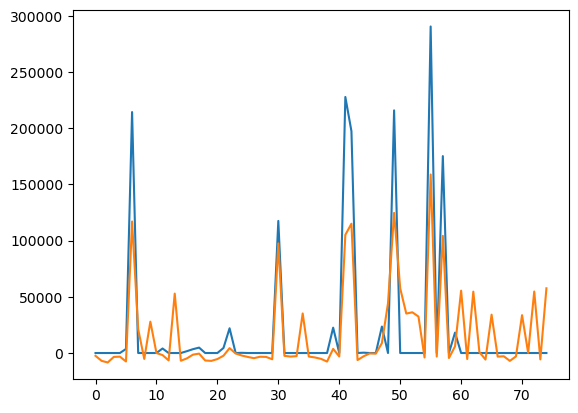

In [30]:
plt.plot(range(len(y_test)),std_y_summer.inverse_transform(y_test))
plt.plot(range(len(y_pred)),std_y_summer.inverse_transform(y_pred.reshape(-1,1)))


In [31]:
feature_fall = df_fall.iloc[:,:-1]
target_fall = df_fall.iloc[:,-1]

std_X_fall = StandardScaler()
std_y_fall = StandardScaler()
std_X_fall.fit(feature_fall)
std_y_fall.fit(target_fall.values.reshape(-1,1))

feature_fall = std_X_fall.transform(feature_fall)
target_fall = std_y_fall.transform(target_fall.values.reshape(-1,1))

X_train, X_test, y_train, y_test = train_test_split(feature_fall, target_fall, test_size=0.2, random_state=19)

lasso_fall = Lasso(alpha=0.1, max_iter=500)
lasso_fall.fit(X_train, y_train)
y_pred = lasso_fall.predict(X_test)
print("rmse :", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R2 score :", r2_score(y_test, y_pred))

rmse : 0.24469526172012993
R2 score : 0.9472950621648976


In [32]:
feature_winter = df_winter.iloc[:,:-1]
target_winter = df_winter.iloc[:,-1]

std_X_winter = StandardScaler()
std_y_winter = StandardScaler()
std_X_winter.fit(feature_winter)
std_y_winter.fit(target_winter.values.reshape(-1,1))

feature_winter = std_X_winter.transform(feature_winter)
target_winter = std_y_winter.transform(target_winter.values.reshape(-1,1))

X_train, X_test, y_train, y_test = train_test_split(feature_winter, target_winter, test_size=0.2, random_state=19)

lasso_winter = Lasso(alpha=0.1, max_iter=500)
lasso_winter.fit(X_train, y_train)
y_pred = lasso_winter.predict(X_test)
print("rmse :", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R2 score :", r2_score(y_test, y_pred))

rmse : 0.33939438954623447
R2 score : -20.641896217142232


In [91]:
feature_total = df_total.iloc[:,:-1]
target_total = df_total.iloc[:,-1]

std_X_total = StandardScaler()
std_y_total = StandardScaler()
std_X_total.fit(feature_total)
std_y_total.fit(target_total.values.reshape(-1,1))

feature_total = std_X_total.transform(feature_total)
target_total = std_y_total.transform(target_total.values.reshape(-1,1))

X_train, X_test, y_train, y_test = train_test_split(feature_total, target_total, test_size=0.2, random_state=19)

lasso_total = Lasso(alpha=0.1, max_iter=500)
lasso_total.fit(X_train, y_train)
y_pred = lasso_total.predict(X_test)
print("rmse :", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R2 score :", r2_score(y_test, y_pred))

rmse : 0.6440706251344874
R2 score : 0.6569825713441181


In [92]:
lasso_total.coef_

array([ 0.        ,  0.        ,  0.        ,  0.        , -0.04088751,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.0818013 , -0.        , -0.        ,
        0.66761112])

In [100]:
std_y_total.inverse_transform(y_pred.reshape(-1,1))

array([[  2674.22490838],
       [127038.75683868],
       [ 11082.68126993],
       [  9670.93417562],
       [  2674.22490838],
       [103924.0177892 ],
       [  2674.22490838],
       [333639.43827728],
       [  2674.22490838],
       [ 25932.91401956],
       [  2674.22490838],
       [ 11082.68126993],
       [  9670.93417562],
       [ 60940.78830932],
       [ 11082.68126993],
       [ 55975.03671538],
       [ 83490.54064754],
       [ 50262.01733188],
       [  2674.22490838],
       [103924.0177892 ],
       [  2674.22490838],
       [ 19528.57798956],
       [ 11082.68126993],
       [  2674.22490838],
       [  2674.22490838],
       [  2674.22490838],
       [103924.0177892 ],
       [103924.0177892 ],
       [  2674.22490838],
       [127038.75683868],
       [ 19528.57798956],
       [  2674.22490838],
       [103924.0177892 ],
       [103924.0177892 ],
       [ 12750.96751811],
       [103924.0177892 ],
       [ 54907.67392932],
       [  2674.22490838],
       [1165

In [33]:
X_train, X_test, y_train, y_test = train_test_split(feature_spring, target_spring, test_size=0.2, random_state=19)

rf_spring = RandomForestRegressor(n_estimators=50, max_depth=3, random_state=19)
rf_spring.fit(X_train, y_train)
y_pred = rf_spring.predict(X_test)
print("rmse :", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R2 score :", r2_score(y_test, y_pred))

rmse : 0.15234357368175308
R2 score : 0.9781061152918745


rmse : 0.28556720733328816
R2 score : 0.9493203634121915


In [36]:
X_train, X_test, y_train, y_test = train_test_split(feature_summer, target_summer, test_size=0.2, random_state=19)

rf_summer = RandomForestRegressor(n_estimators=50, max_depth=3, random_state=19)
rf_summer.fit(X_train, y_train)
y_pred = rf_summer.predict(X_test)
print("rmse :", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R2 score :", r2_score(y_test, y_pred))

rmse : 0.28556720733328816
R2 score : 0.9493203634121915


In [37]:
X_train, X_test, y_train, y_test = train_test_split(feature_fall, target_fall, test_size=0.2, random_state=19)

rf_fall = RandomForestRegressor(n_estimators=50, max_depth=3, random_state=19)
rf_fall.fit(X_train, y_train)
y_pred = rf_fall.predict(X_test)
print("rmse :", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R2 score :", r2_score(y_test, y_pred))

rmse : 0.22825100954181973
R2 score : 0.954140892317559


In [38]:
X_train, X_test, y_train, y_test = train_test_split(feature_winter, target_winter, test_size=0.2, random_state=19)

rf_winter = RandomForestRegressor(n_estimators=50, max_depth=3, random_state=19)
rf_winter.fit(X_train, y_train)
y_pred = rf_winter.predict(X_test)
print("rmse :", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R2 score :", r2_score(y_test, y_pred))

rmse : 0.07166210011337455
R2 score : 0.035138327475423115


In [97]:
# df_winter.loc[("전라남도")]

In [98]:
X_train, X_test, y_train, y_test = train_test_split(feature_total, target_total, test_size=0.2, random_state=19)

rf_total = RandomForestRegressor(n_estimators=50, max_depth=3, random_state=19)
rf_total.fit(X_train, y_train)
y_pred = rf_total.predict(X_test)
print("rmse :", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R2 score :", r2_score(y_test, y_pred))

rmse : 0.5198378067175028
R2 score : 0.7765476502924265
